In [1]:
import pandas as pd
import numpy as np
import random,os
import torch.utils.data as Data
from sklearn.metrics import f1_score,recall_score,precision_score,roc_curve,auc,accuracy_score,confusion_matrix,r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import torch
# import torch.nn as nn
from torch import nn,optim
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
import gc
import time
import math
import matplotlib.pyplot as plt

In [3]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # print('1',out.shape)
        out = self.bn2(self.conv2(out))
        # print('2',out.shape)
        out += self.shortcut(x)
        # print('3',out.shape)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.input_channel = 1
        self.in_planes = 64
        

        self.conv1 = nn.Conv2d(self.input_channel, self.in_planes, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*4, num_classes)
        self.dropout = nn.Dropout(0.2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # print(out.shape)
        out = self.layer1(out)
        # out = self.dropout(out)
        out = self.layer2(out)
        # out = self.dropout(out)
        out = self.layer3(out)
        # out = self.dropout(out)
        out = self.layer4(out)
        # out = self.dropout(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                reg_loss += torch.sum(torch.abs(m.weight))
        return reg_loss

    def l1reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                reg_loss += torch.sum(torch.abs(m.weight))
        return reg_loss

    def l12reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                reg_loss += torch.sum((torch.abs(m.weight) + 1e-6).sqrt())
        return reg_loss

    def l23reg_loss(self):
        reg_loss = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                reg_loss += torch.sum((torch.abs(m.weight) + 1e-6).pow(2/3))
        return reg_loss

    def exact_sparsity(self):
        nnz = 0
        total_param = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                total_param += np.prod(m.weight.data.shape)
                nnz += torch.sum(m.weight.data != 0).detach().item()
        ratio = nnz / total_param
        return ratio
    
    def sparsity_level(self):
        nnz_2 = 0.0
        nnz_3 = 0.0
        nnz_4 = 0.0
        total_param = 0.0
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                total_param += np.prod(m.weight.data.shape)
                nnz_2 += torch.sum(m.weight.data.abs() >= 0.01).detach().item()
                nnz_3 += torch.sum(m.weight.data.abs() >= 0.001).detach().item()
                nnz_4 += torch.sum(m.weight.data.abs() >= 0.0001).detach().item()
        ratio_2 = nnz_2 / total_param
        ratio_3 = nnz_3 / total_param
        ratio_4 = nnz_4 / total_param
        return ratio_2, ratio_3 


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])
def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

In [4]:
path1='/root/ResNet/'
path_name = os.path.join(path1,'micedata.csv')
df = pd.read_csv(path_name,header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,10338,10339,10340,10341,10342,10343,10344,10345,10346,10347
0,0.738094,-0.023996,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
1,0.743638,0.037044,1,1,2,1,1,1,1,2,...,0,0,0,0,0,0,0,0,2,0
2,0.431086,-0.082434,2,0,2,2,0,2,0,2,...,0,0,0,0,0,0,0,0,2,2
3,0.144433,0.017911,1,1,1,1,1,1,1,2,...,0,0,0,0,0,0,0,0,2,0
4,0.675366,-0.040148,2,0,2,2,0,2,0,2,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,-0.157640,0.021284,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,2,2
1810,0.751668,-0.073322,1,1,2,1,1,1,1,2,...,0,0,0,0,0,0,0,0,2,2
1811,0.186213,0.056111,1,1,2,1,1,1,1,2,...,0,0,0,0,0,0,0,0,2,2
1812,-0.779898,0.020232,1,1,1,1,1,1,1,2,...,0,0,0,1,0,0,0,2,2,0


In [5]:
X = df.iloc[:,2:]
Y = df.iloc[:,:2]

In [6]:
from sklearn.preprocessing import OneHotEncoder


# 初始化OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# 选择要进行独热编码的列
cols_to_encode = df.columns[2:]

# 拟合训练集
encoder.fit(X)

# 对训练集和测试集进行转换
X_encoded = encoder.transform(X)
                             

/root/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
pd.DataFrame(X_encoded)

,0,1,2,3,4,5,6,7,8,9,...,30977,30978,30979,30980,30981,30982,30983,30984,30985,30986
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1810,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1811,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1812,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [7]:

# 假设data是一个形状为(N, 30987)的数组
padding = np.zeros((X_encoded.shape[0], 31329 - X_encoded.shape[1]))
data_padded = np.concatenate([X_encoded, padding], axis=1)
# 然后，将数据重塑为(n, 177, 177, 1)
data_reshaped = data_padded.reshape(-1, 1,177, 177)
data_reshaped.shape

(1814, 1, 177, 177)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_reshaped,Y , test_size=0.2, random_state=42)

In [9]:
def z_score(data):
    data = data.astype(float)
    Mean = data.mean()
    Var = ((data - Mean)**2).mean()
    Std = pow(Var,0.5)
    data = (data - Mean)/Std  # 标准化
    return Mean,Std,data
Mean,Std,Y_train = z_score(Y_train)
Y_test = (Y_test - Mean)/Std

In [10]:
Y_train = Y_train.values
Y_test = Y_test.values

In [11]:
Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)

X_train = torch.tensor(X_train,dtype = torch.float)
Y_train  = torch.tensor(Y_train,dtype = torch.float)

X_test = torch.tensor(X_test,dtype = torch.float)
Y_test  = torch.tensor(Y_test,dtype = torch.float)
print(X_train.shape, Y_train.shape,X_test.shape, Y_test.shape)

torch.Size([1451, 1, 177, 177]) torch.Size([1451, 2]) torch.Size([363, 1, 177, 177]) torch.Size([363, 2])


In [12]:
train_loader = Data.DataLoader(
    dataset=Data.TensorDataset(X_train, Y_train),  # 封装进Data.TensorDataset()类的数据，可以为任意维度
    batch_size=35,  # 每块的大小
    shuffle=True,  
    drop_last =True, #丢弃最后一组数据
    num_workers=0,  # 多进程（multiprocess）来读数据
)
test_loader = Data.DataLoader(
    dataset=Data.TensorDataset(X_test, Y_test),  # 封装进Data.TensorDataset()类的数据，可以为任意维度
    batch_size=35,  # 每块的大小
    shuffle=False,  
    drop_last =True, 
    num_workers=0,  
)

In [13]:
class AdamL12(Optimizer):
    r""" Implements Adam with L0 regularization
    
    A General Family of Proximal Methods for Stochastic Preconditioned Gradient Descent

    This family contains the Adam-type curvature estimate and
    L0 (non-convex, non-smooth) regularizer

    For this optimizer, the update rule is somewhat adaptive hard-thresholding
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, amsgrad=False, penalty=0.0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        penalty=penalty)
        super(AdamL12, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamL12, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault("amsgrad", False)

    def step(self, closure=None):
        """ Performs a single optimization step.
        
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform weight-decay
                p.data.mul_(1 - group['lr'] * group['weight_decay'])

                # Perform optimization step
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
            
                state['step'] += 1 
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)
                    
                if len(p.data.shape) == 2 or len(p.data.shape) == 4:
                    threshold = (54 ** (1/3) / 4) * ((2 * group['penalty'] * group['lr'] / denom) ** (2/3))
                    mask = p.data.abs() > threshold
                    mask = mask.float()

                    zero_mask = p.data.abs() <= threshold
                    zero_mask = zero_mask.float() + 1e-4
                    
                    p.data.mul_(mask)
                    factor = (group['lr'] * group['penalty'] / denom) / 4
                    angle = factor * (((p.data.abs() + zero_mask) / 3) ** (-1.5))
                    angle = angle * mask
                    angle = torch.acos(angle)

                    value = p.data * (2/3) * (1 + torch.cos(2/3 * (math.pi - angle)))
                    p.data = value * mask

        return loss

class AdamL23(Optimizer):
    r""" Implements Adam with L0 regularization
    
    A General Family of Proximal Methods for Stochastic Preconditioned Gradient Descent

    This family contains the Adam-type curvature estimate and
    L0 (non-convex, non-smooth) regularizer

    For this optimizer, the update rule is somewhat adaptive hard-thresholding
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=1e-2, amsgrad=False, penalty=0.0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        penalty=penalty)
        super(AdamL23, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamL23, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault("amsgrad", False)

    def step(self, closure=None):
        """ Performs a single optimization step.
        
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform weight-decay
                p.data.mul_(1 - group['lr'] * group['weight_decay'])

                # Perform optimization step
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
            
                state['step'] += 1 
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)
                    
                if len(p.data.shape) == 2 or len(p.data.shape) == 4:
                    eff_lam = 2 * group['lr'] * group['penalty'] / denom
                    threshold = (2/3) * (3 * eff_lam ** 3) ** (1/4)
                    mask = p.data.abs() > threshold
                    mask = mask.float()
                    
                    zero_mask = p.data.abs() <= threshold
                    zero_mask = zero_mask.float() * 100
                    
                    p.data.mul_(mask)
                    angle = acosh((27/16) * (p.data ** 2 + zero_mask) * (eff_lam ** (-1.5)))
                    angle = angle * mask
                    absA = (2/math.sqrt(3)) * (eff_lam ** (1/4)) * (torch.cosh(angle/3) ** (1/2))

                    value = ((absA + torch.sqrt(2 * (p.data.abs() + zero_mask) / absA - absA ** 2)) / 2) ** 3

                    p.data = p.data.sign() * value * mask

        return loss

In [14]:
Epochs                = 100      # 训练轮数
l                     = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def seed_torch():
    seed=1029
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_torch()
model = ResNet18()
model = model.to(device)
loss_function = nn.MSELoss()  # loss
optimizer = AdamL12(model.parameters(), lr=l)  # 优化器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.95)
LOSS = float('inf')
result = {}
result['train-loss']= []
result['test-loss']= []
start_time1 = time.time()
for epochs in range(Epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    test_loss  = 0
    for data_l in train_loader:
        seq, labels = data_l
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()                          #    清空过往梯度 
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)    #    获取loss：输入预测值和标签，计算损失函数
        single_loss.backward()                         #    反向传播，计算当前梯度
        optimizer.step()                               #    根据梯度更新网络参数
        train_loss += single_loss.item()
    train_loss = train_loss/len(train_loader)
    scheduler.step()
    model.eval()
    for data_l in test_loader:
        seq, labels = data_l
        seq, labels = seq.to(device), labels.to(device)
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)    #    获取loss：输入预测值和标签，计算损失函数
        test_loss += single_loss.item()
    test_loss = test_loss/len(test_loader)
    if LOSS > test_loss:
        LOSS =test_loss
        torch.save(model, 'model_cnn1.pth')
        print('已更新保存模型')
    result['train-loss'].append(train_loss)
    result['test-loss'].append(test_loss)
    del seq, labels ,y_pred #删除数据与变量
    gc.collect() #清除数据与变量相关的缓存
    torch.cuda.empty_cache() #缓存分配器分配出去的内存给释放掉
    epoch_time = time.time() - start_time
    print('Epochs',epochs,'loss_train',train_loss,'loss_test',test_loss,'每轮耗时：',epoch_time)
all_time = time.time() - start_time1
print('总耗时:',all_time)

/tmp/ipykernel_12234/1815375738.py:77: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


已更新保存模型
Epochs 0 loss_train 11.807511844286104 loss_test 0.9608611464500427 每轮耗时： 2.696747064590454
Epochs 1 loss_train 1.0263680743008126 loss_test 1.022716325521469 每轮耗时： 2.139242649078369
Epochs 2 loss_train 0.7847797725258804 loss_test 1.1344991445541381 每轮耗时： 2.163578748703003
Epochs 3 loss_train 0.6241064638626285 loss_test 1.1654046773910522 每轮耗时： 2.1543164253234863
Epochs 4 loss_train 0.5401823513391542 loss_test 1.066801017522812 每轮耗时： 2.1954596042633057
Epochs 5 loss_train 0.4629551979099832 loss_test 1.2285907030105592 每轮耗时： 2.113521099090576
Epochs 6 loss_train 0.38179868168947173 loss_test 1.1009924769401551 每轮耗时： 2.1219799518585205
Epochs 7 loss_train 0.35302598520023065 loss_test 1.1940136194229125 每轮耗时： 2.120434522628784
Epochs 8 loss_train 0.2598665614680546 loss_test 1.0649650335311889 每轮耗时： 2.110954999923706
Epochs 9 loss_train 0.1862877278429706 loss_test 1.1671190559864044 每轮耗时： 2.1552650928497314
Epochs 10 loss_train 0.18443967401981354 loss_test 1.126584994792938

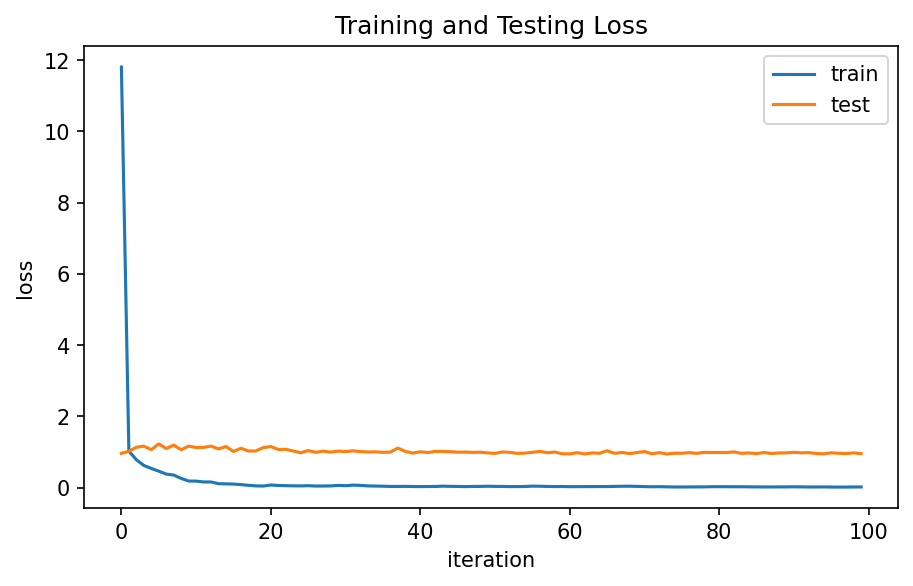

In [15]:
import matplotlib.pyplot as plt
plt.figure(dpi=150,figsize=(7,4))
plt.plot(result['train-loss'][:], label='train')
plt.plot(result['test-loss'][:], label='test')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.savefig('resnet18loss.jpg',dpi=150)
plt.show()

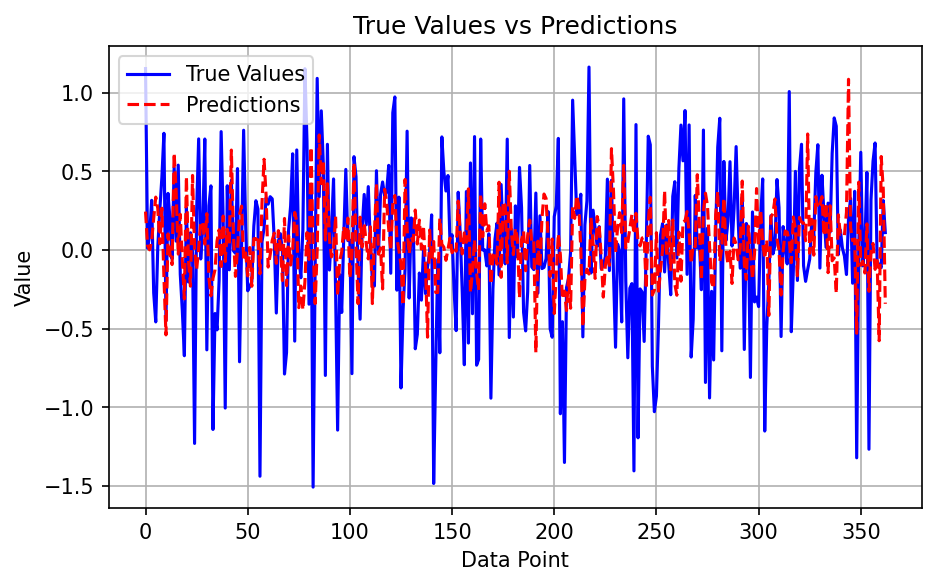

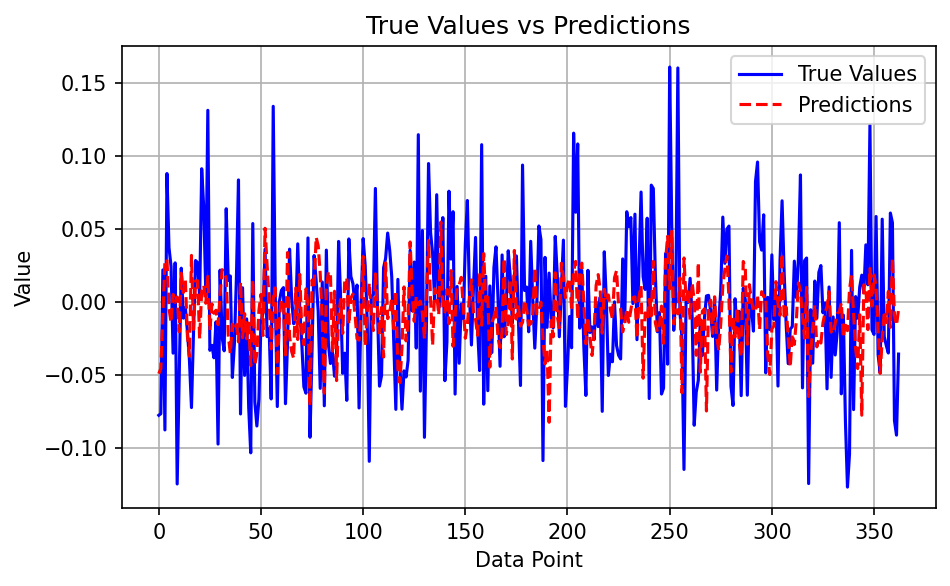

In [16]:

def load_model(model_path):

    if torch.cuda.is_available():
        model = torch.load(model_path)
    else:
        model = torch.load(model_path, map_location=torch.device('cpu'))

    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model('model_cnn1.pth')
pre = model(X_test.to(device))
pre = pre.cpu().detach().numpy()
Y_test1 = Y_test.cpu().detach().numpy().copy()
for i in range(pre.shape[1]):
    pre[:,i] = pre[:,i]*Std[i] +Mean[i]
    Y_test1[:,i] = Y_test1[:,i]*Std[i] +Mean[i]
    plt.figure(dpi=150,figsize=(7,4))
    plt.plot(Y_test1[:,i], label='True Values', color='blue')
    plt.plot(pre[:,i], label='Predictions', linestyle='--', color='red')
    plt.title('True Values vs Predictions')
    plt.xlabel('Data Point')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.savefig('cnn_对比图_{}.jpg'.format(i),dpi=150)
    plt.show()

In [17]:
def Evaluation_index(Y_test1,pre):
    from sklearn.metrics import r2_score, mean_squared_error,explained_variance_score,mean_absolute_error
    r2 = r2_score(Y_test1,pre)
    ev = explained_variance_score(Y_test1,pre)
    mse = mean_squared_error(Y_test1,pre)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test1,pre)

    pre = pre.reshape(-1)
    Y_test1 = Y_test1.reshape(-1)
    INDEX = []
    page = 0
    for i in Y_test1:
        if i ==0:
            INDEX.append(page)
        page +=1
    if INDEX !=[]:
        Y_test1 = np.delete(Y_test1,INDEX,0)
        pre     = np.delete(pre,INDEX,0)
    mape = (sum(abs((pre - Y_test1)/(Y_test1)))/len(Y_test1))
    evaluation_index = pd.DataFrame()
    evaluation_index['评估指标名称'] = ['r2','ev','mse','rmse','mae','mape']
    evaluation_index['评估指标值'] = [r2,ev,mse,rmse,mae,mape]
    print('r2:',r2)
    print('ev:',ev)
    print('mse:',mse)
    print('rmse:',rmse)
    print('mae:',mae)
    print('mape:',mape)
    return evaluation_index
for i in range(2):
    evaluation_index = Evaluation_index(Y_test1[:,i],pre[:,i])
    evaluation_index.to_csv(f'evaluation_index{i}.csv',index = False)
    print('-----------------')

r2: -0.008865259466388498
ev: -0.004652142524719238
mse: 0.25108612
rmse: 0.5010849
mae: 0.39673805
mape: 4.544346958492464
-----------------
r2: -0.007583855101972681
ev: -0.0046814680099487305
mse: 0.0024099718
rmse: 0.049091462
mae: 0.038532577
mape: 3.532211827343848
-----------------


In [18]:
evaluation_index = Evaluation_index(Y_test1,pre)

r2: -0.008224557469441729
ev: -0.004666924476623535
mse: 0.12674804
rmse: 0.3560169
mae: 0.21763532
mape: 4.038279392918156
